## Evaluating Graph Embeddings in Minkowski Spacetime

In [39]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# plotting style
%matplotlib inline
plt.style.use('seaborn')
# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

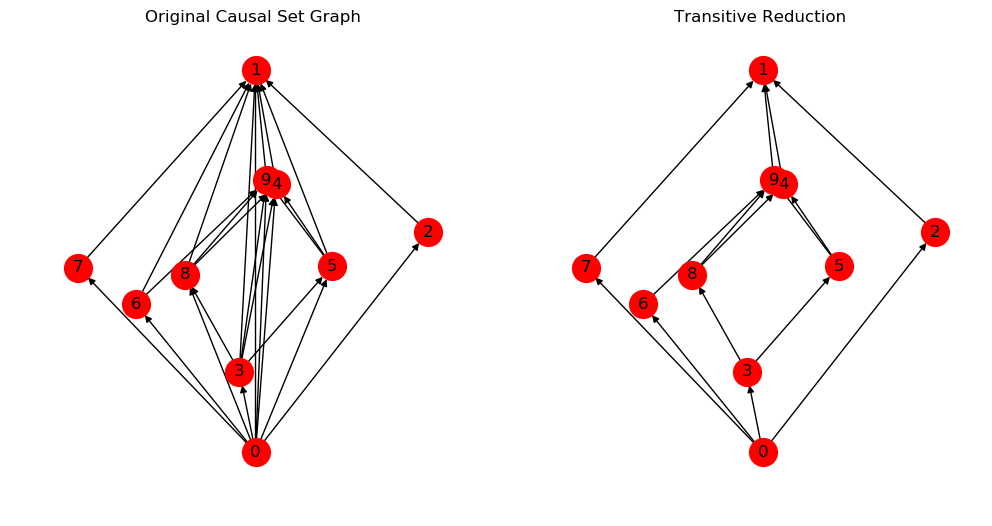

In [46]:
from sample_graphs import causal_set_graph, uniform_box_graph
from eval_metrics import add_edges, roc_auc_score, plot_roc_curve, sensitivity, specificity
import dag_embed

# plot causal set graph & transitive reduction
N = 10
G = causal_set_graph(N, 2)
options = {'node_size': 400,
           'width': 1,
           'with_labels': True}
draw_pos = {i:G.node[i]['position'][::-1] for i in range(N)}
trans_G = nx.transitive_reduction(G)
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw(G, pos=draw_pos, **options)
plt.title('Original Causal Set Graph')
plt.subplot(122)
plt.title('Transitive Reduction')
nx.draw(trans_G, pos=draw_pos, **options);

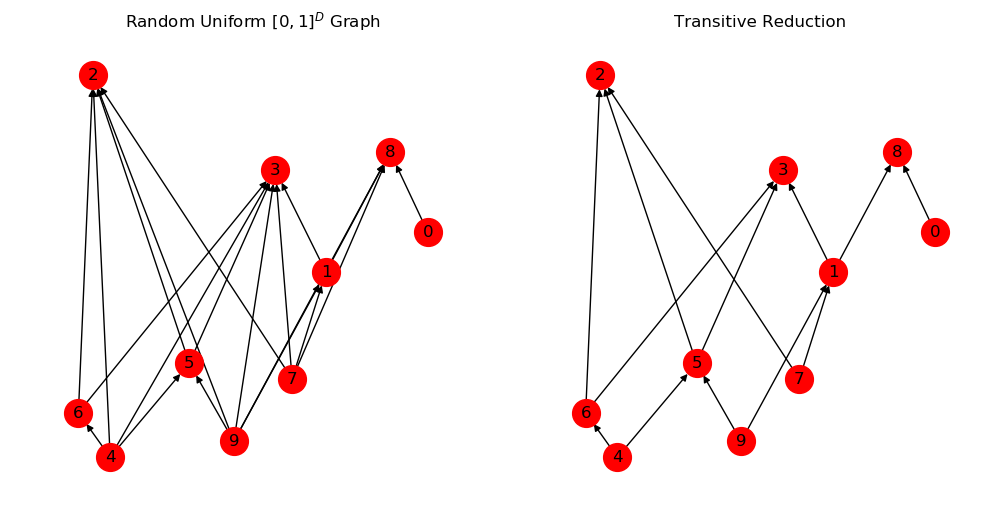

In [47]:
# plot uniform rectangle graph and transitive reduction
N = 10
G = uniform_box_graph(N, 2)
draw_pos = {i:G.node[i]['position'][::-1] for i in range(N)}
trans_G = nx.transitive_reduction(G)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(r'Random Uniform $[0,1]^D$ Graph')
nx.draw(G, pos=draw_pos, **options)
plt.subplot(122)
plt.title('Transitive Reduction')
nx.draw(trans_G, pos=draw_pos, **options);

## Ex 1.) Synthetic Graph Data

Note: how to handle embeddings where time direction is reversed?

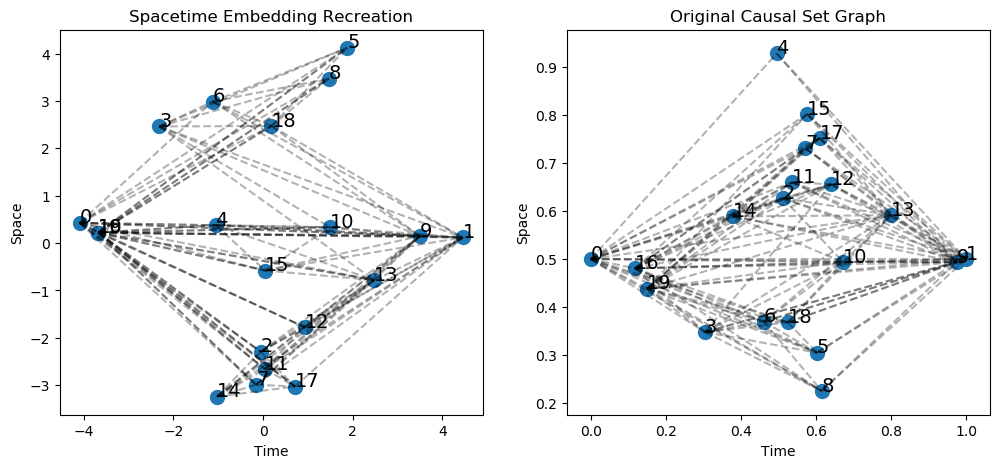

In [48]:
# evaluate on causal set graph
from dag_embed import MinkowskiEmbedding
N = 20
G = causal_set_graph(N, 2)
embed = MinkowskiEmbedding(n_components=2) 
X = embed.fit(G)
plt.figure(figsize=(12,5))
plt.style.use('default')
plt.subplot(121)
plt.title('Spacetime Embedding Recreation')
plt.xlabel('Time')
plt.ylabel('Space')
plt.scatter(X[:, 0], X[:, 1], s=100)
for i in range(N):
    _ = plt.text(X[i, 0], X[i, 1], str(i), size=14);
for u,v in add_edges(X):
    _ = plt.plot([X[u][0], X[v][0]], [X[u][1], X[v][1]], c='black', linestyle='--', alpha=0.3);
plt.subplot(122)
plt.title('Original Causal Set Graph')
plt.xlabel('Time')
plt.ylabel('Space')
X_orig = np.array([G.node[i]['position'] for i in range(N)])
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=100)
for i in range(N):
    _ = plt.text(X_orig[i, 0], X_orig[i, 1], str(i), size=14);
for u,v in list(G.edges()):
    _ = plt.plot([X_orig[u][0], X_orig[v][0]], [X_orig[u][1], X_orig[v][1]], 
                 alpha=0.3, c='black', linestyle='--');
plt.show();

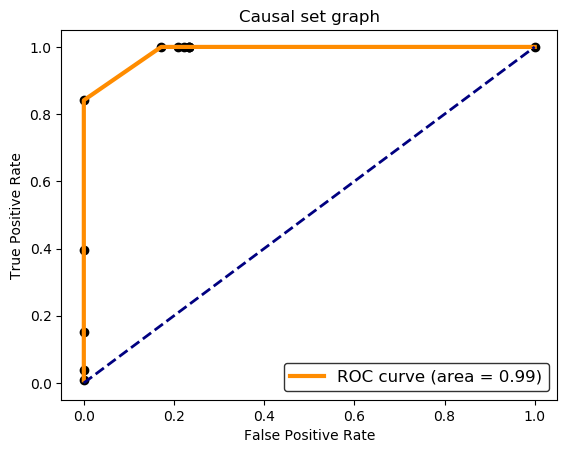

In [49]:
# evaluate over several random causal set graphs
causal_graph_scores = []
N = 20
for i in range(20):
    G = sample_graphs.causal_set_graph(N, 2)
    embed = MinkowskiEmbedding(n_components=2) 
    X = embed.fit(G)
    causal_graph_scores.append(roc_auc_score(G, X))

# plot roc curve
plot_roc_curve(G, X, title='Causal set graph')
sensitivity(G, embed.predict(G))
specificity(G, embed.predict(G))
roc_auc_score(G, X);

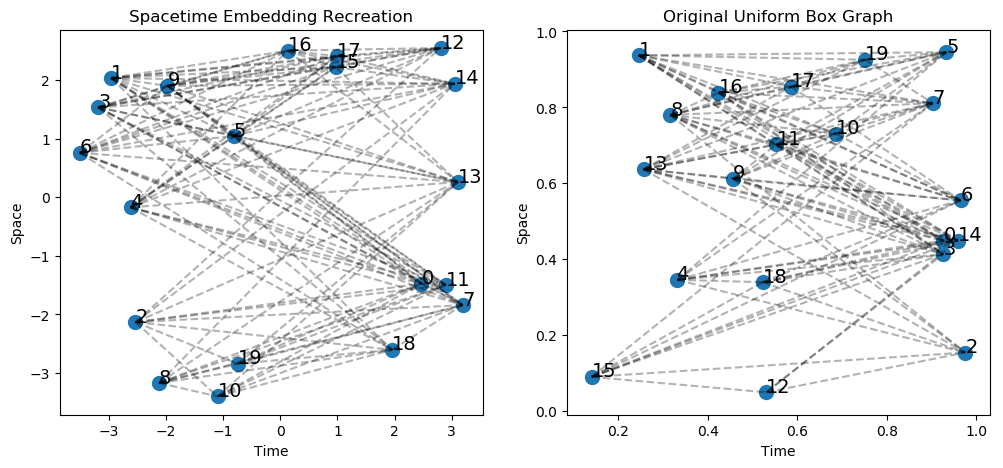

In [50]:
# evaluate on uniform box graph
N = 20
G = uniform_box_graph(N, 2)
embed = MinkowskiEmbedding(n_components=2) 
X = embed.fit(G)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Spacetime Embedding Recreation')
plt.xlabel('Time')
plt.ylabel('Space')
plt.scatter(X[:, 0], X[:, 1], s=100)
for i in range(N):
    _ = plt.text(X[i, 0], X[i, 1], str(i), size=14);
for u,v in add_edges(X):
    _ = plt.plot([X[u][0], X[v][0]], [X[u][1], X[v][1]], c='black', alpha=0.3, linestyle='--');
plt.subplot(122)
plt.title('Original Uniform Box Graph')
plt.xlabel('Time')
plt.ylabel('Space')
X_orig = np.array([G.node[i]['position'] for i in range(N)])
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=100)
for i in range(N):
    _ = plt.text(X_orig[i, 0], X_orig[i, 1], str(i), size=14);
for u,v in list(G.edges()):
    _ = plt.plot([X_orig[u][0], X_orig[v][0]], [X_orig[u][1], X_orig[v][1]], 
                 c='black', alpha=0.3, linestyle='--');
plt.show();

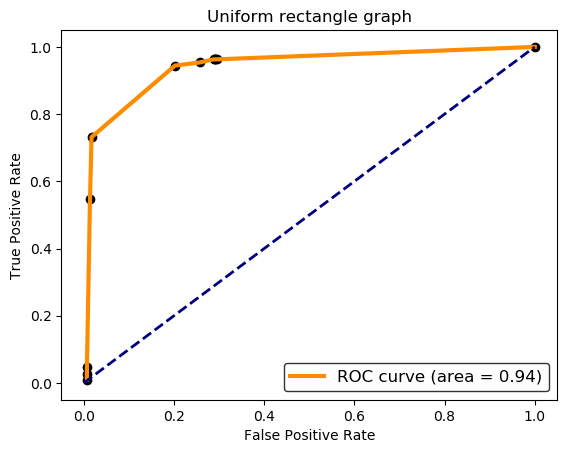

In [51]:
# evaluate over several random causal set graphs
box_graph_scores = []
N = 20
for i in range(20):
    G = causal_set_graph(N, 2)
    embed = MinkowskiEmbedding(n_components=2) 
    X = embed.fit(G)
    box_graph_scores.append(roc_auc_score(G, X))

# plot roc curve
plot_roc_curve(G, X, title='Uniform rectangle graph')
sensitivity(G, embed.predict(G))
specificity(G, embed.predict(G))
roc_auc_score(G, X);

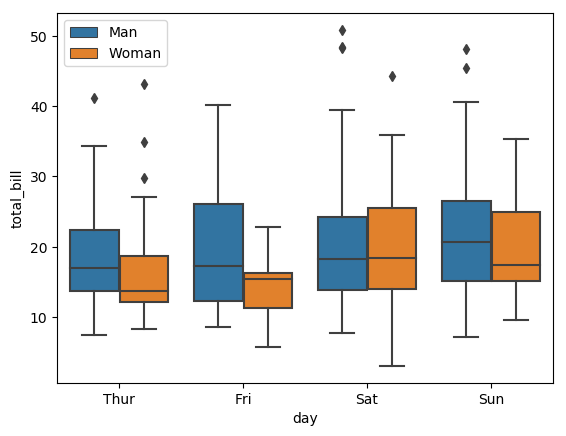

In [87]:
tips = sns.load_dataset("tips")
ax = sns.boxplot(x="day", y="total_bill", hue="sex", data=tips)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Man", "Woman"])

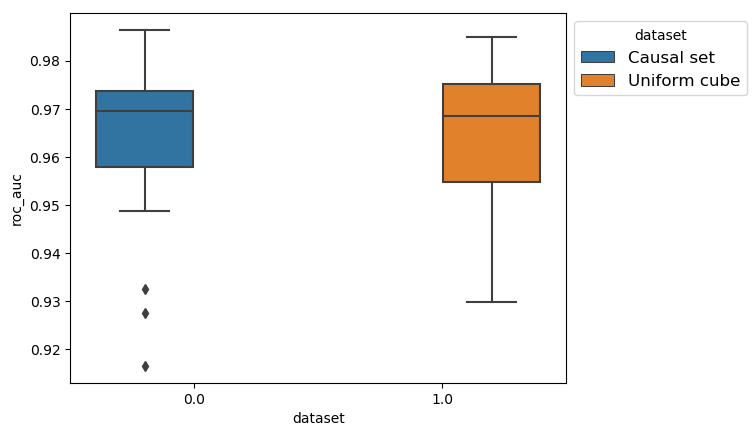

In [96]:
import pandas as pd
test_data = list(np.repeat(0, len(causal_graph_scores))) + list(np.repeat(1, len(box_graph_scores)))
test_scores = list(causal_graph_scores) + list(box_graph_scores)
test_labels = list(np.repeat('Causal set', len(causal_graph_scores))) + list(np.repeat('Uniform_cube_graph', len(box_graph_scores)))
result_df = pd.DataFrame(np.hstack((np.array(test_data).reshape(-1,1), np.array(test_scores).reshape(-1,1))),
                        columns=['dataset', 'roc_auc'])
ax = sns.boxplot(data=result_df, x='dataset', y='roc_auc', hue="dataset");
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Causal set", "Uniform cube"], title='dataset', fontsize=12, loc='upper left', bbox_to_anchor=(1, 1));